In [1]:
import pandas as pd
import sklearn
import numpy as np
import util
import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pydotplus
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dtreeviz.trees import dtreeviz
import lightgbm as lgb

In [3]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm 
import matplotlib.pylab as plt 
from dmba import regressionSummary, exhaustive_search 
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import backward_elimination, forward_selection

In [4]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 81)

In [5]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)
feature = pd.read_csv('Data/Created Datasets/KSI_Feature_Collapse.csv', index_col = 0)
count = pd.read_csv('Data/Created Datasets/KSI_Collapse_Count_truncate3.csv')

In [6]:
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)

In [242]:
ultimate_df.isna().sum()

IncidentsTotal       0
SeverityScore        0
PercentOfVehicles    0
AvgAcceleration      0
LATITUDE             0
LONGITUDE            0
COUNT                0
INVAGE               0
RDSFCOND             0
VISIBILITY           0
LIGHT                0
TRAFFCTL             0
DRIVACT              0
DRIVCOND             0
TIME                 0
dtype: int64

In [367]:
# TREATING ACTUAL NULLS INTRODUCED BECAUSE OF THE RIGHT MERGE OF HAZARDOUS WITH ROAD IMPEDIMENTS
# THOSE VALUES WILL BECOME 0s SINCE THERE WERE NO HARSH BREAKING INCIDENTS AT THOSE PLACES

ultimate_df.fillna(ultimate_df.mean(), inplace = True)

In [161]:
ultimate_df.isna().sum()

IncidentsTotal       0
SeverityScore        0
PercentOfVehicles    0
AvgAcceleration      0
LATITUDE             0
LONGITUDE            0
COUNT                0
INVAGE               0
RDSFCOND             0
VISIBILITY           0
LIGHT                0
TRAFFCTL             0
DRIVACT              0
DRIVCOND             0
TIME                 0
dtype: int64

In [162]:
print(ultimate_df['DRIVCOND'].unique())
print(ultimate_df['DRIVACT'].unique())
print(ultimate_df['LIGHT'].unique())
print(ultimate_df['TRAFFCTL'].unique())
print(ultimate_df['VEHTYPE'].unique())
print(ultimate_df['INVAGE'].unique())
#print(ultimate_df['MANOEUVER'].unique())

['Normal' 'Inattentive' '<Null>' 'Ability Impaired (Drugs/Alcohol)'
 'Unknown' 'Medical or Physical Disability' 'Other' 'Fatigue']
['Improper Turn' 'Failed to Yield Right of Way' '<Null>' 'Lost control'
 'Improper Passing' 'Disobeyed Traffic Control' 'Improper Lane Change'
 'Speed too Fast For Condition' 'Speeding' 'Following too Close' 'Other'
 'Wrong Way on One Way Road']
['Daylight' 'Artificial' 'Dark' 'Dusk' 'Dawn']
['Traffic Signal' 'No Control' 'Stop/Yield Sign' 'Streetcar (Stop for)'
 'Controller present' 'Pedestrian Crossover']
['Adult' 'Senior' 'Super Senior' 'Young Adult' 'Children']


In [7]:
ultimate_df = ultimate_df.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [369]:
ultimate_df.head()

,IncidentsTotal,SeverityScore,PercentOfVehicles,AvgAcceleration,LATITUDE,LONGITUDE,COUNT,INVAGE,RDSFCOND,VISIBILITY,LIGHT,TRAFFCTL,DRIVACT,DRIVCOND,VEHTYPE,TIME
0,8,0.022,0.069,0.421,43.593,-79.538,3,Adult,Dry,Clear,Daylight,Traffic Signal,Improper Turn,Normal,Small-size Vehicle,1647.333333
1,8,0.022,0.069,0.421,43.593,-79.538,3,Adult,Dry,Clear,Artificial,Traffic Signal,Improper Turn,Inattentive,Small-size Vehicle,1647.333333
2,8,0.022,0.069,0.421,43.593,-79.538,3,Senior,Dry,Clear,Daylight,Traffic Signal,Failed to Yield Right of Way,Inattentive,Small-size Vehicle,1647.333333
3,3,0.007,0.033,0.419,43.610,-79.561,2,Super Senior,Wet,Rain,Dark,Traffic Signal,0,0,Small-size Vehicle,2022.000000
4,3,0.002,0.047,0.309,43.613,-79.560,1,Adult,Dry,Clear,Dark,Traffic Signal,Failed to Yield Right of Way,Inattentive,Small-size Vehicle,1835.000000


In [18]:
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude', 'IncidentsTotal')]]


X = pd.get_dummies(X)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

X = X[[col for col in X.columns if '0' not in col]]

In [371]:
X.shape

(706, 56)

In [27]:
# ONLY RUN THESE FOR LIGHTGBM

X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude', 'IncidentsTotal')]]


#X = pd.get_dummies(X)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

# ABSOLUTELY IMPORTANT STEP

for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
        X[c] = X[c].cat.codes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [374]:
# Does the model perform better than the null model?
# Our created models must be able to beat this:
# I'm comparing valid_Y to the mean of COUNT. 

regressionSummary(valid_Y, np.repeat(Y.mean(), valid_Y.shape))


Regression statistics

                      Mean Error (ME) : 0.1343
       Root Mean Squared Error (RMSE) : 2.1135
            Mean Absolute Error (MAE) : 1.6914
          Mean Percentage Error (MPE) : -54.8264
Mean Absolute Percentage Error (MAPE) : 86.1793


In [9]:
param_grid = { 
 'max_depth': [3, 2, 4, 5, 6, 7, 8,10, 11, 12, 13, 14, 15], 
 'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001], 
 'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005] 
} 

In [20]:
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state = 1), param_grid, cv = 5, n_jobs = -1)
gridSearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14,
                                       15],
                         'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001],
                         'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005]})

In [11]:
gridSearch.best_estimator_

DecisionTreeRegressor(max_depth=10, min_impurity_decrease=0.02,
                      min_samples_split=0.005, random_state=1)

In [208]:
viz = dtreeviz(gridSearch.best_estimator_, valid_X, valid_Y,
               target_name="COUNT",
               feature_names= valid_X.columns,
               title="test")

viz.save("decision_tree_wine.svg")

C:\Users\kwanv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [380]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(gridSearch.best_estimator_, 
                           feature_names=valid_X.columns, 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
#graph

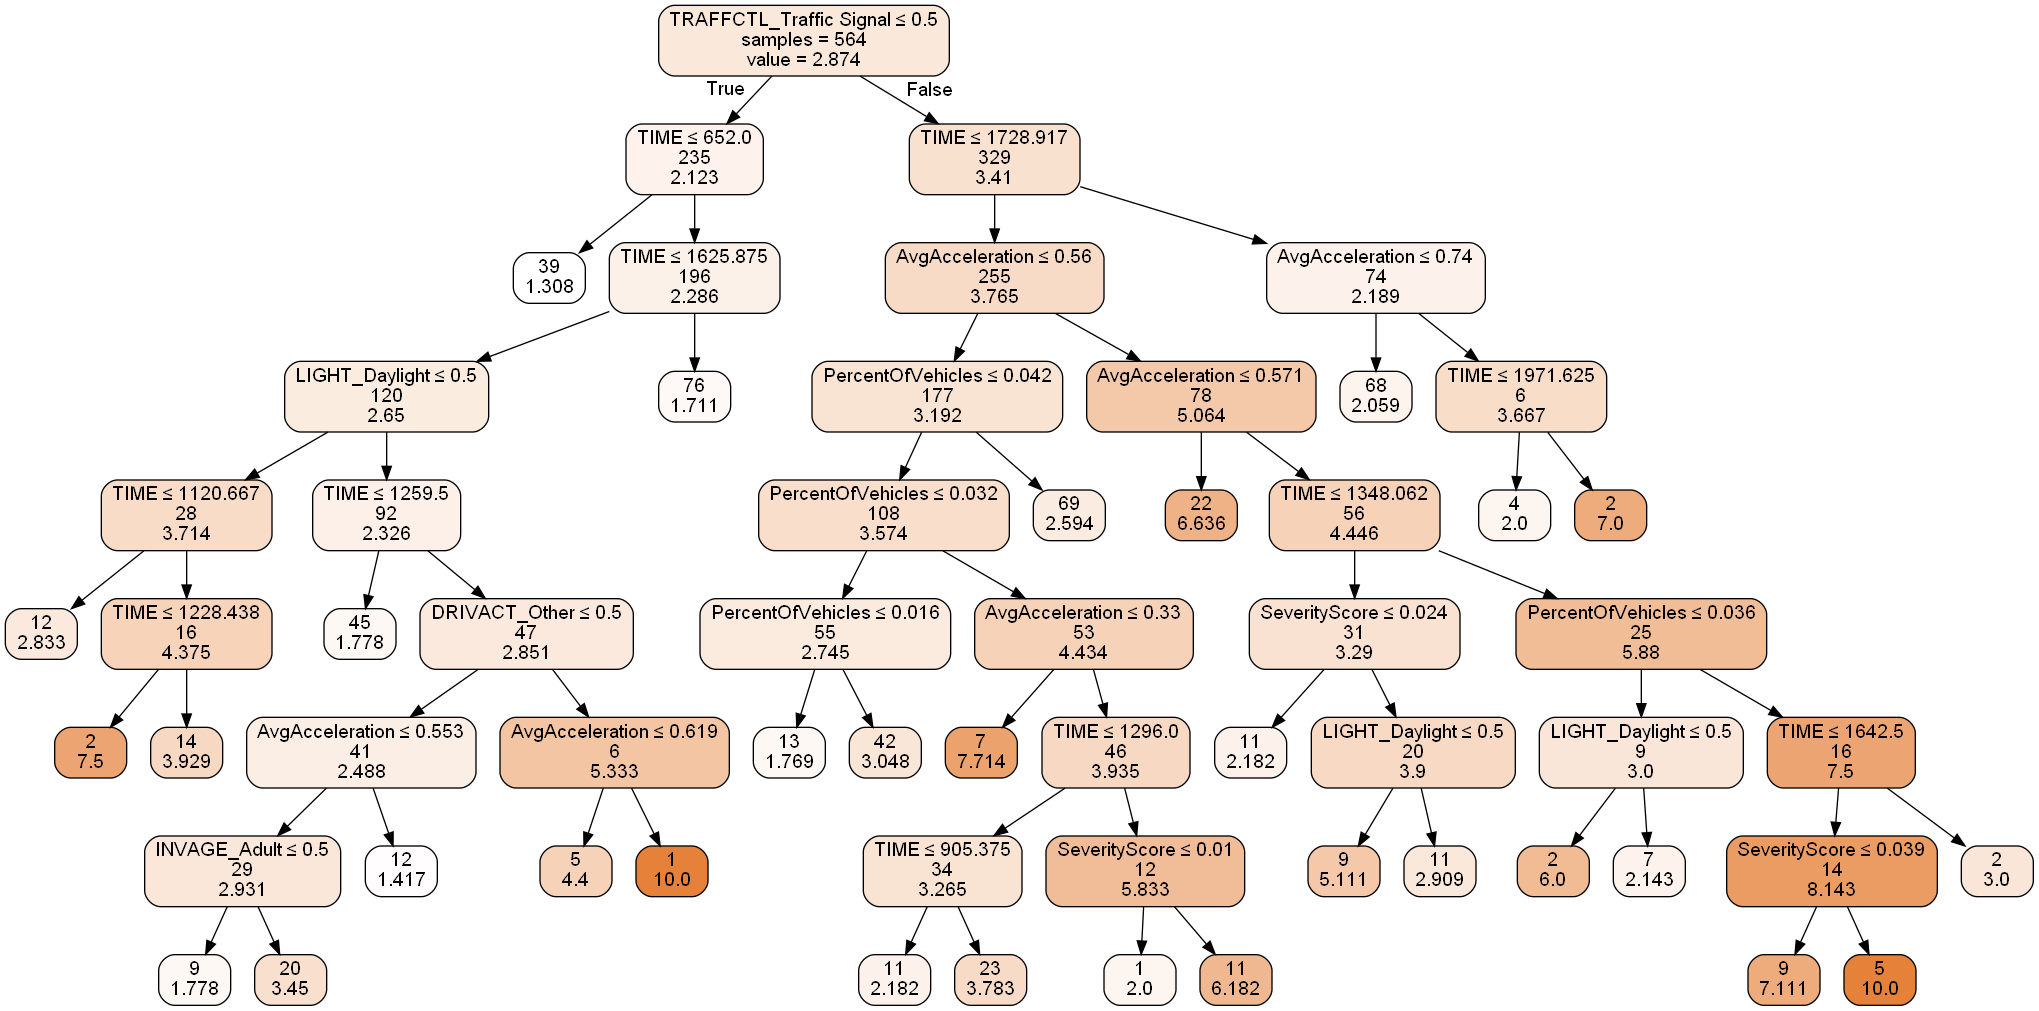

In [21]:
plotDecisionTree(gridSearch.best_estimator_, train_X.columns)

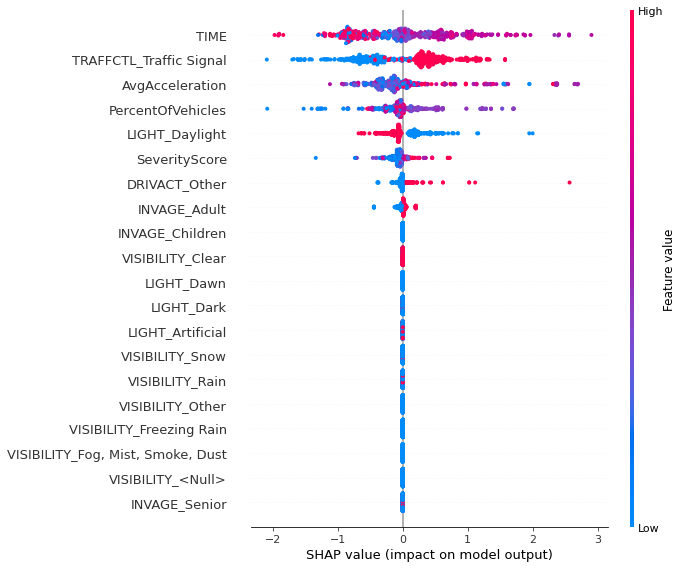

In [23]:
explainer = shap.TreeExplainer(gridSearch.best_estimator_)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X)

In [22]:
print(regressionSummary(train_Y, gridSearch.best_estimator_.predict(train_X)))
regressionSummary(valid_Y, gridSearch.best_estimator_.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.9991
            Mean Absolute Error (MAE) : 0.7816
          Mean Percentage Error (MPE) : -21.0338
Mean Absolute Percentage Error (MAPE) : 41.8624
None

Regression statistics

                      Mean Error (ME) : 0.0737
       Root Mean Squared Error (RMSE) : 1.5517
            Mean Absolute Error (MAE) : 1.0878
          Mean Percentage Error (MPE) : -26.6705
Mean Absolute Percentage Error (MAPE) : 53.1573


In [474]:
fit_params={"early_stopping_rounds": 50, 
            "eval_metric" : 'l2', 
            "eval_set" : [(valid_X, valid_Y), (train_X, train_Y)],
            'eval_names': ['valid','train'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto' # automatically deals with cat features
           }
           
lgbreg = lgb.LGBMRegressor(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='l2', 
                         n_jobs= -1, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

lgbreg.fit(train_X, train_Y, **fit_params)

[100]	train's l2: 0.25853	valid's l2: 1.11575
[200]	train's l2: 0.082854	valid's l2: 0.976553
[300]	train's l2: 0.0339062	valid's l2: 0.951407


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


LGBMRegressor(colsample_bytree=0.9, metric='l2', n_estimators=1000,
              num_leaves=15, random_state=314, silent=True, subsample=0.9)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

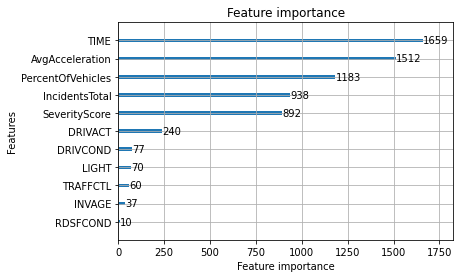

In [466]:
lgb.plot_importance(lgbreg)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

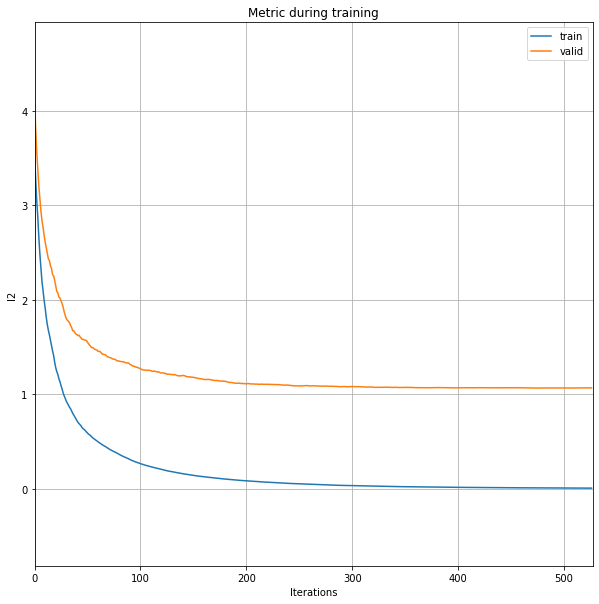

In [467]:
lgb.plot_metric(lgbreg, figsize = (10,10))

<AxesSubplot:>

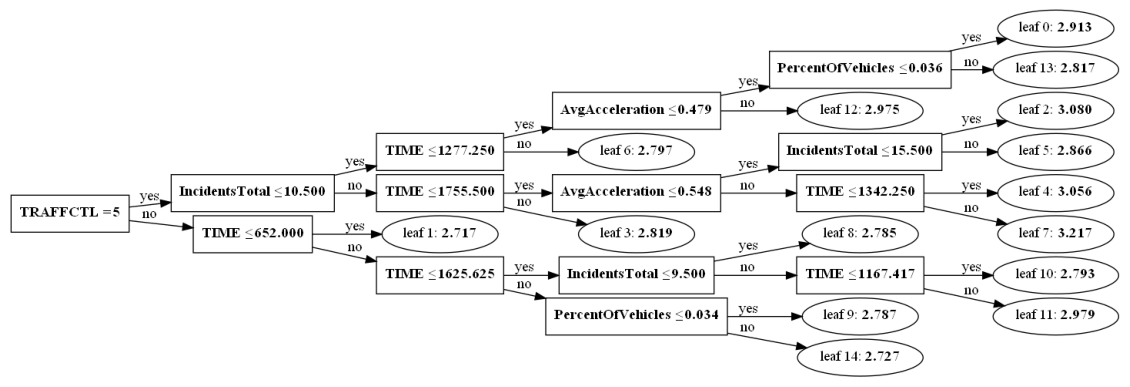

In [468]:
lgb.plot_tree(lgbreg ,figsize=(20,20))

In [24]:
print(regressionSummary(train_Y, lgbreg.predict(train_X)))
regressionSummary(valid_Y, lgbreg.predict(valid_X))

NameError: name 'lgbreg' is not defined

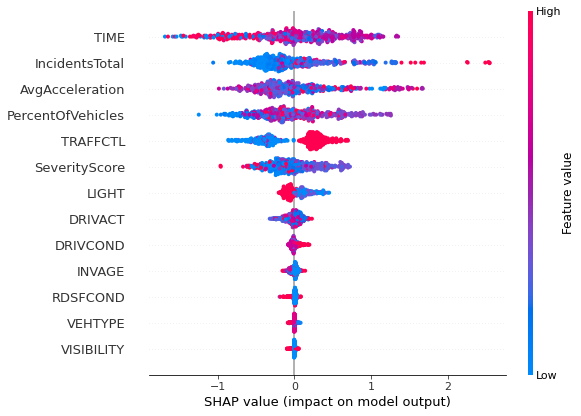

In [475]:
explainer = shap.Explainer(lgbreg)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X)

In [11]:
rf = RandomForestRegressor(n_estimators = 4000, random_state = 1) 
rf.fit(train_X, train_Y)

RandomForestRegressor(n_estimators=4000, random_state=1)

Text(0.5, 1.0, 'Visualizing Important Features')

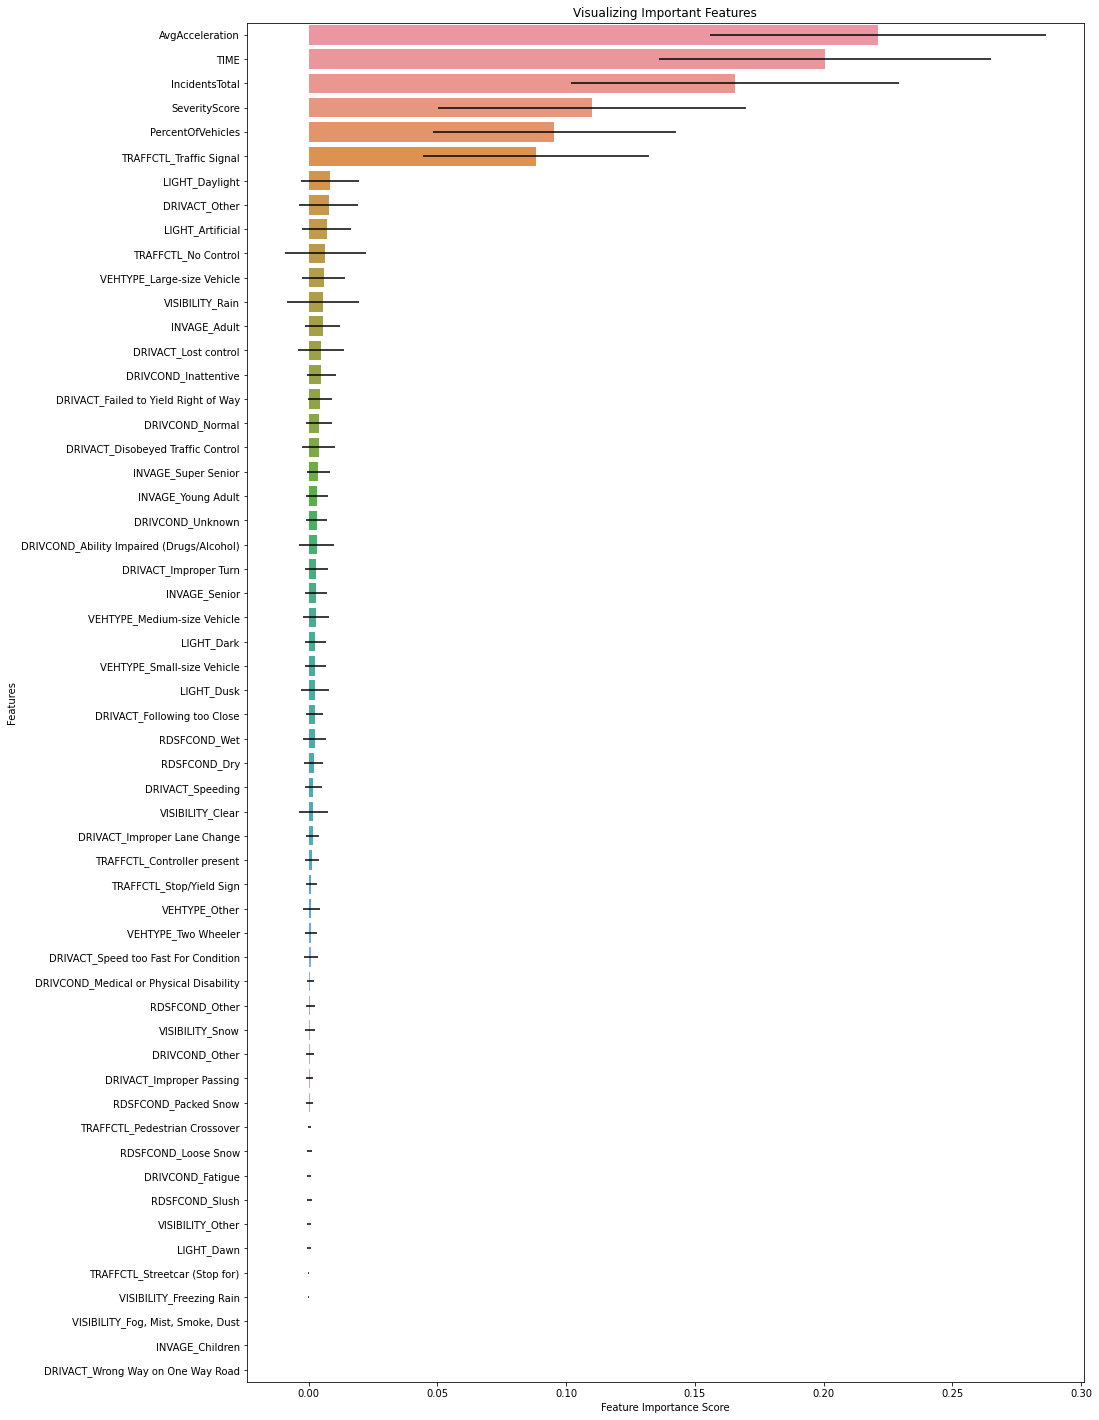

In [12]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0) 
tf = pd.DataFrame({'feature': train_X.columns, 'importance': rf.feature_importances_, 'std': std}) 
tf = tf.sort_values('importance', ascending = False)
plt.figure(figsize = (15,25))
sns.barplot(x = tf['importance'], y = tf['feature'], xerr = tf['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [13]:
print(regressionSummary(train_Y, rf.predict(train_X)))
regressionSummary(valid_Y, rf.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0483
       Root Mean Squared Error (RMSE) : 0.4303
            Mean Absolute Error (MAE) : 0.3135
          Mean Percentage Error (MPE) : -13.0157
Mean Absolute Percentage Error (MAPE) : 19.0896
None

Regression statistics

                      Mean Error (ME) : -0.1096
       Root Mean Squared Error (RMSE) : 1.1337
            Mean Absolute Error (MAE) : 0.8540
          Mean Percentage Error (MPE) : -34.9550
Mean Absolute Percentage Error (MAPE) : 51.1484


In [14]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X)

KeyboardInterrupt: 

In [25]:
linear_model = LinearRegression()
linear_model.fit(train_X, train_Y)

LinearRegression()

In [26]:
print(regressionSummary(train_Y, linear_model.predict(train_X)))
regressionSummary(valid_Y, linear_model.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1.7691
            Mean Absolute Error (MAE) : 1.3669
          Mean Percentage Error (MPE) : -41.8089
Mean Absolute Percentage Error (MAPE) : 67.9624
None

Regression statistics

                      Mean Error (ME) : 0.0696
       Root Mean Squared Error (RMSE) : 1.9980
            Mean Absolute Error (MAE) : 1.5403
          Mean Percentage Error (MPE) : -45.0210
Mean Absolute Percentage Error (MAPE) : 75.3080


Estimating transforms: 100%|██████████| 1000/1000 [00:05<00:00, 197.62it/s]


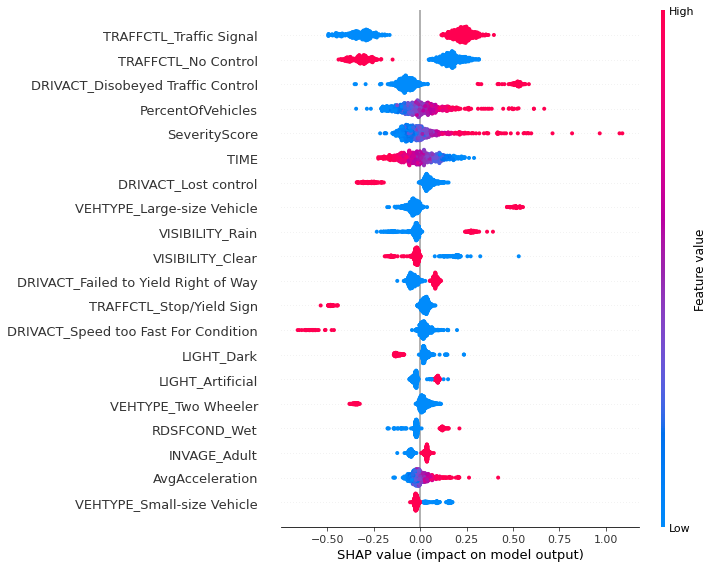

In [27]:
explainer = shap.Explainer(linear_model, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [16]:
pd.DataFrame({'Actual': valid_Y, 'Predicted': linear_model.predict(valid_X)})

,Actual,Predicted
605,1,3.077022
425,2,3.883513
334,1,2.240182
457,4,3.492829
187,1,1.106790
...,...,...
119,4,3.749239
82,6,3.887263
615,4,2.882834
311,3,1.247555


(0.55, 10.45, -0.3724958409578613, 7.2599123998292265)

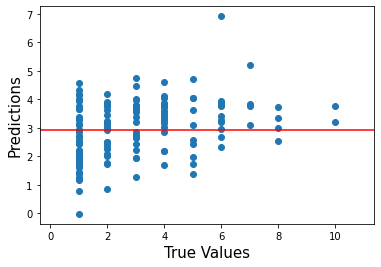

In [28]:
predicted_value = linear_model.predict(valid_X)
#true_value = valid_Y
plt.scatter(valid_Y, linear_model.predict(valid_X))
plt.axhline(y = Y.mean(), color = 'r', linestyle = '-')
#p1 = max(max(predicted_value), max(true_value))
#p2 = min(min(predicted_value), min(true_value))
#plt.plot([p1, p2],[p1, p2], 'r-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')

In [181]:
valid_X.head(1)

,IncidentsTotal,SeverityScore,PercentOfVehicles,AvgAcceleration,TIME,INVAGE_Adult,INVAGE_Children,INVAGE_Senior,INVAGE_Super Senior,INVAGE_Young Adult,RDSFCOND_Dry,RDSFCOND_Loose Snow,RDSFCOND_Other,RDSFCOND_Packed Snow,RDSFCOND_Slush,RDSFCOND_Wet,VISIBILITY_Clear,"VISIBILITY_Fog, Mist, Smoke, Dust",VISIBILITY_Freezing Rain,VISIBILITY_Other,VISIBILITY_Rain,VISIBILITY_Snow,LIGHT_Artificial,LIGHT_Dark,LIGHT_Dawn,LIGHT_Daylight,LIGHT_Dusk,TRAFFCTL_Controller present,TRAFFCTL_No Control,TRAFFCTL_Pedestrian Crossover,TRAFFCTL_Stop/Yield Sign,TRAFFCTL_Streetcar (Stop for),TRAFFCTL_Traffic Signal,DRIVACT_Disobeyed Traffic Control,DRIVACT_Failed to Yield Right of Way,DRIVACT_Following too Close,DRIVACT_Improper Lane Change,DRIVACT_Improper Passing,DRIVACT_Improper Turn,DRIVACT_Lost control,DRIVACT_Other,DRIVACT_Speed too Fast For Condition,DRIVACT_Speeding,DRIVACT_Wrong Way on One Way Road,DRIVCOND_Ability Impaired (Drugs/Alcohol),DRIVCOND_Fatigue,DRIVCOND_Inattentive,DRIVCOND_Medical or Physical Disability,DRIVCOND_Normal,DRIVCOND_Other,DRIVCOND_Unknown
605,9,0.035,0.073,0.387,1707.0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [182]:
pred_input = valid_X.head(1)
#pred_input['AvgAcceleration'] = 1.2
#pred_input['DRIVCOND_Ability Impaired (Drugs/Alcohol)'] = 0
pred_input['INVAGE_Senior'] = 0

<ipython-input-182-77e6b131e3c0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_input['INVAGE_Senior'] = 0


In [183]:
linear_model.predict(pred_input)

array([3.03225962])

In [387]:
pd.DataFrame({'Feature': train_X.columns, 'coefficients': linear_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
2,PercentOfVehicles,5.971820e+00
24,LIGHT_Dawn,2.285236e+00
33,DRIVACT_Disobeyed Traffic Control,1.472355e+00
36,DRIVACT_Improper Lane Change,1.173316e+00
13,RDSFCOND_Packed Snow,1.086931e+00
32,TRAFFCTL_Traffic Signal,9.781678e-01
34,DRIVACT_Failed to Yield Right of Way,9.508297e-01
40,DRIVACT_Other,8.001078e-01
51,VEHTYPE_Large-size Vehicle,7.862598e-01
38,DRIVACT_Improper Turn,7.507312e-01


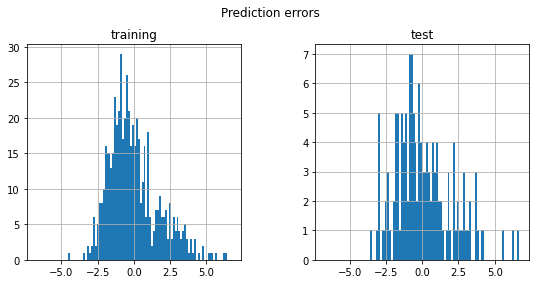

In [388]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - linear_model.predict(train_X), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - linear_model.predict(valid_X), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [29]:
# these helper functions have been obtained from the book. but it must be noted that there is a fatal flaw with them
# they assume the existence of a train_Y - not good practice, and will probably throw errors if shared with others

def train_model(variables): 
    if len(variables) == 0: 
        return None 
    model = LinearRegression() 
    model.fit(train_X[variables], train_Y) 
    return model 
    
def score_model(model, variables): 
    if len(variables) == 0: 
        return AIC_score(train_Y, [train_Y.mean()] * len(train_Y), model, df=1) 
    return AIC_score(train_Y, model.predict(train_X[variables]), model) 

In [30]:
forwards_model, best_variables_forward = forward_selection(train_X.columns, train_model, score_model, verbose = True)

Variables: SeverityScore, PercentOfVehicles, AvgAcceleration, TIME, INVAGE_Adult, INVAGE_Children, INVAGE_Senior, INVAGE_Super Senior, INVAGE_Young Adult, RDSFCOND_<Null>, RDSFCOND_Dry, RDSFCOND_Loose Snow, RDSFCOND_Other, RDSFCOND_Packed Snow, RDSFCOND_Slush, RDSFCOND_Wet, VISIBILITY_<Null>, VISIBILITY_Clear, VISIBILITY_Fog, Mist, Smoke, Dust, VISIBILITY_Freezing Rain, VISIBILITY_Other, VISIBILITY_Rain, VISIBILITY_Snow, LIGHT_Artificial, LIGHT_Dark, LIGHT_Dawn, LIGHT_Daylight, LIGHT_Dusk, TRAFFCTL_Controller present, TRAFFCTL_No Control, TRAFFCTL_Pedestrian Crossover, TRAFFCTL_Stop/Yield Sign, TRAFFCTL_Streetcar (Stop for), TRAFFCTL_Traffic Signal, DRIVACT_<Null>, DRIVACT_Disobeyed Traffic Control, DRIVACT_Failed to Yield Right of Way, DRIVACT_Following too Close, DRIVACT_Improper Lane Change, DRIVACT_Improper Passing, DRIVACT_Improper Turn, DRIVACT_Lost control, DRIVACT_Other, DRIVACT_Speed too Fast For Condition, DRIVACT_Speeding, DRIVACT_Wrong Way on One Way Road, DRIVCOND_<Null>, 

In [31]:
print(regressionSummary(train_Y, forwards_model.predict(train_X[best_variables_forward])))
regressionSummary(valid_Y, forwards_model.predict(valid_X[best_variables_forward]))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1.7998
            Mean Absolute Error (MAE) : 1.3811
          Mean Percentage Error (MPE) : -43.0611
Mean Absolute Percentage Error (MAPE) : 68.4789
None

Regression statistics

                      Mean Error (ME) : 0.1017
       Root Mean Squared Error (RMSE) : 2.0215
            Mean Absolute Error (MAE) : 1.5603
          Mean Percentage Error (MPE) : -45.7448
Mean Absolute Percentage Error (MAPE) : 75.2336


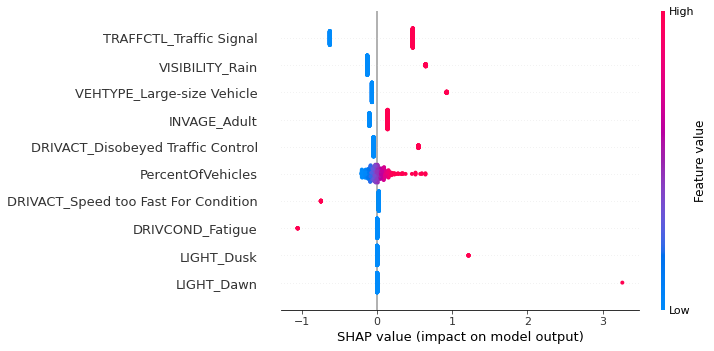

In [32]:
masker = shap.maskers.Independent(data= valid_X[best_variables_forward])
explainer = shap.Explainer(forwards_model, masker= masker,
                           feature_names= train_X[best_variables_forward].columns, algorithm="linear")
shap_values = explainer.shap_values(train_X[best_variables_forward])
shap.summary_plot(shap_values, train_X[best_variables_forward])

(0.4597630892482264,
 10.454296995750084,
 0.4597630892482264,
 10.454296995750084)

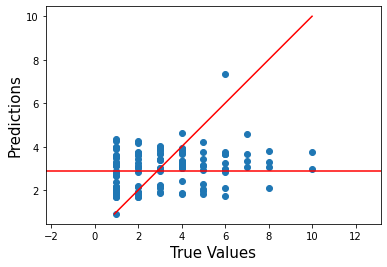

In [33]:
predicted_value = forwards_model.predict(valid_X[best_variables_forward])
true_value = valid_Y
plt.scatter(valid_Y, forwards_model.predict(valid_X[best_variables_forward]))
plt.axhline(y = Y.mean(), color = 'r', linestyle = '-')
p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2],[p1, p2], 'r-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)

plt.axis('equal')

In [34]:
pd.DataFrame({'Feature': best_variables_forward, 'coefficients': forwards_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
8,PercentOfVehicles,5.290439
7,LIGHT_Dawn,3.263644
4,LIGHT_Dusk,1.216140
0,TRAFFCTL_Traffic Signal,1.104191
2,VEHTYPE_Large-size Vehicle,0.994354
1,VISIBILITY_Rain,0.777804
3,DRIVACT_Disobeyed Traffic Control,0.596962
9,INVAGE_Adult,0.242951
5,DRIVACT_Speed too Fast For Condition,-0.771975
6,DRIVCOND_Fatigue,-1.057880


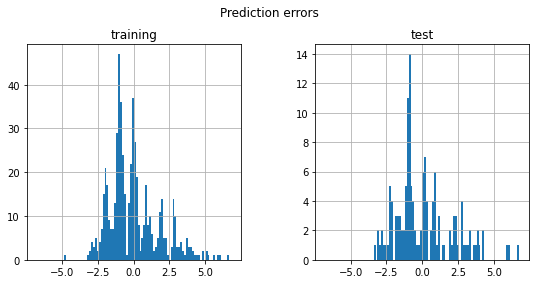

In [22]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - forwards_model.predict(train_X[best_variables_forward]), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - forwards_model.predict(valid_X[best_variables_forward]), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [24]:
backwards_model, best_variables_backward = backward_elimination(train_X.columns, train_model, score_model, verbose = False)

In [25]:
pd.DataFrame({'Feature': best_variables_backward, 'coefficients': backwards_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
1,PercentOfVehicles,5.659903
5,LIGHT_Dawn,3.121379
6,LIGHT_Dusk,1.220287
7,TRAFFCTL_Traffic Signal,1.077019
8,DRIVACT_Disobeyed Traffic Control,0.656625
0,IncidentsTotal,0.005255
10,VEHTYPE_Medium-size Vehicle,-0.649763
3,VISIBILITY_Clear,-0.706558
12,VEHTYPE_Small-size Vehicle,-0.924024
4,VISIBILITY_Snow,-0.984993
